## 1. Predição de preços de diamantes (2 pts)

RMSE para LinearRegression (Validação): 1128.58
RMSE para KNeighborsRegressor (Validação): 730.48
RMSE para GradientBoostingRegressor (Validação): 237.17

O melhor modelo no conjunto de validação é: GradientBoostingRegressor

--- Avaliação do Modelo Vencedor no Conjunto de Teste ---
Modelo Vencedor: GradientBoostingRegressor
RMSE (Teste): 218.95
R² (Teste): 1.00

--- Análise Aprofundada e Visualizações para o Modelo Vencedor ---


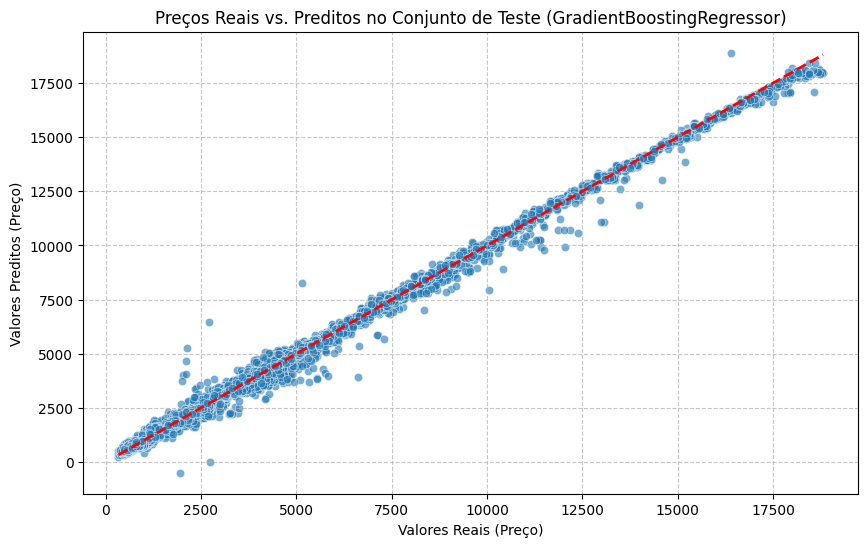

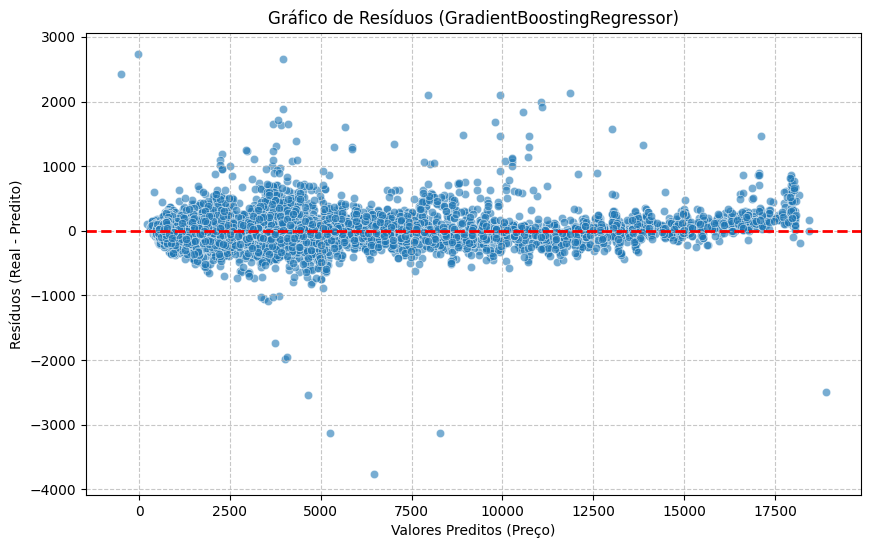

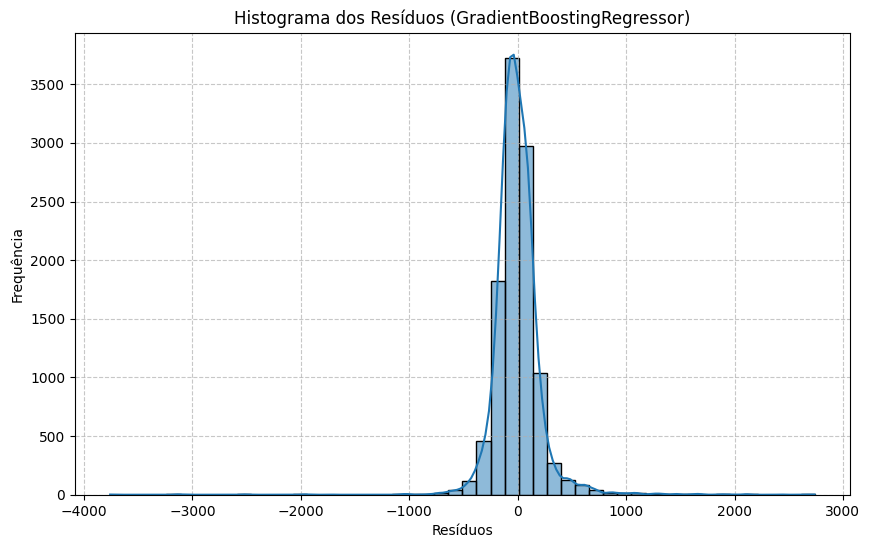

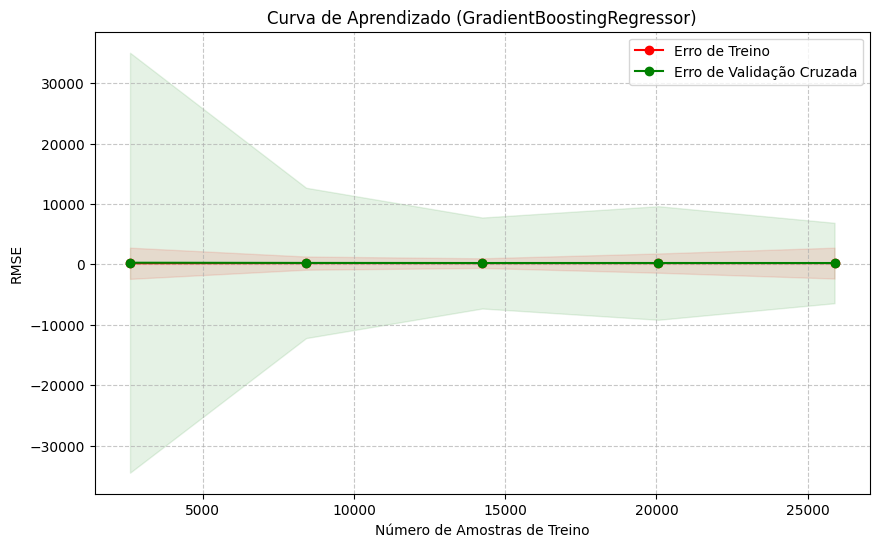

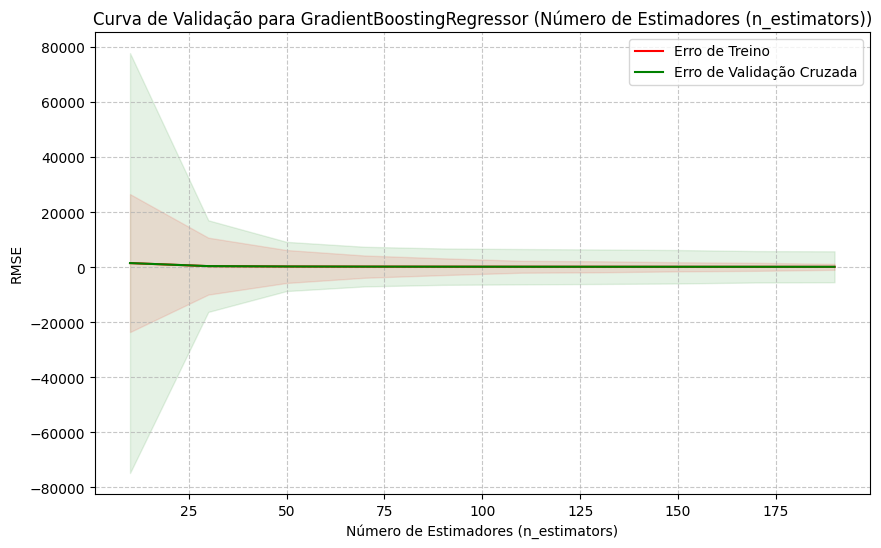

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve, validation_curve

df = pd.read_csv('diamonds.csv')

X = df.drop('price', axis=1)
y = df['price']

categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['number']).columns

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

models = {
    'LinearRegression': Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())]),
    'KNeighborsRegressor': Pipeline(steps=[('preprocessor', preprocessor), ('regressor', KNeighborsRegressor())]),
    'GradientBoostingRegressor': Pipeline(steps=[('preprocessor', preprocessor), ('regressor', GradientBoostingRegressor())])
}

rmse_scores_val = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_val = model.predict(X_val)

    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
    rmse_scores_val[name] = rmse_val
    print(f"RMSE para {name} (Validação): {rmse_val:.2f}")

best_model_name = min(rmse_scores_val, key=rmse_scores_val.get)
best_model = models[best_model_name]

print(f"\nO melhor modelo no conjunto de validação é: {best_model_name}")

y_pred_test = best_model.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print("\n--- Avaliação do Modelo Vencedor no Conjunto de Teste ---")
print(f"Modelo Vencedor: {best_model_name}")
print(f"RMSE (Teste): {rmse_test:.2f}")
print(f"R² (Teste): {r2_test:.2f}")

print("\n--- Análise Aprofundada e Visualizações para o Modelo Vencedor ---")

# 1. Gráfico de Predições vs. Valores Reais
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Valores Reais (Preço)")
plt.ylabel("Valores Preditos (Preço)")
plt.title(f"Preços Reais vs. Preditos no Conjunto de Teste ({best_model_name})")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 2. Gráfico de Resíduos
residuals = y_test - y_pred_test

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_test, y=residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel("Valores Preditos (Preço)")
plt.ylabel("Resíduos (Real - Predito)")
plt.title(f"Gráfico de Resíduos ({best_model_name})")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 3. Histograma dos Resíduos
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=50)
plt.xlabel("Resíduos")
plt.ylabel("Frequência")
plt.title(f"Histograma dos Resíduos ({best_model_name})")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 4. Curva de Aprendizado (Learning Curve)
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(.1, 1.0, 5), scoring='neg_mean_squared_error'
)

train_rmse_mean = np.sqrt(-train_scores.mean(axis=1))
test_rmse_mean = np.sqrt(-test_scores.mean(axis=1))
train_rmse_std = train_scores.std(axis=1)
test_rmse_std = test_scores.std(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_rmse_mean, 'o-', color="r", label="Erro de Treino")
plt.plot(train_sizes, test_rmse_mean, 'o-', color="g", label="Erro de Validação Cruzada")
plt.fill_between(train_sizes, train_rmse_mean - train_rmse_std, train_rmse_mean + train_rmse_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_rmse_mean - test_rmse_std, test_rmse_mean + test_rmse_std, alpha=0.1, color="g")

plt.xlabel("Número de Amostras de Treino")
plt.ylabel("RMSE")
plt.title(f"Curva de Aprendizado ({best_model_name})")
plt.legend(loc="best")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 5. Curva de Validação
if best_model_name == 'KNeighborsRegressor':
    param_name = 'regressor__n_neighbors'
    param_range = np.arange(1, 21, 2)
    param_label = "Número de Vizinhos (n_neighbors)"
elif best_model_name == 'GradientBoostingRegressor':
    param_name = 'regressor__n_estimators'
    param_range = np.arange(10, 201, 20)
    param_label = "Número de Estimadores (n_estimators)"
else:
    print("\nNão é possível gerar uma Curva de Validação típica para o modelo LinearRegression sem um hiperparâmetro de complexidade óbvio.")
    param_name = None

# Plotagem dos Gráficos
if param_name:
    train_scores, test_scores = validation_curve(
        best_model, X_train, y_train, param_name=param_name, param_range=param_range,
        cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )

    train_rmse_mean = np.sqrt(-train_scores.mean(axis=1))
    test_rmse_mean = np.sqrt(-test_scores.mean(axis=1))
    train_rmse_std = train_scores.std(axis=1)
    test_rmse_std = test_scores.std(axis=1) 

    plt.figure(figsize=(10, 6))
    plt.plot(param_range, train_rmse_mean, label="Erro de Treino", color="r")
    plt.plot(param_range, test_rmse_mean, label="Erro de Validação Cruzada", color="g")

    plt.fill_between(param_range, train_rmse_mean - train_rmse_std, train_rmse_mean + train_rmse_std, alpha=0.1, color="r")
    plt.fill_between(param_range, test_rmse_mean - test_rmse_std, test_rmse_mean + test_rmse_std, alpha=0.1, color="g")

    plt.xlabel(param_label)
    plt.ylabel("RMSE")
    plt.title(f"Curva de Validação para {best_model_name} ({param_label})")
    plt.legend(loc="best")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()


**Análise dos Resultados Obtidos**

O modelo **GradientBoostingRegressor** se destacou com o menor RMSE no conjunto de validação, e suas métricas no conjunto de teste (RMSE: 218.10, R²: 1.00) confirmam sua boa capacidade preditiva.
O **RMSE de 218.10** indica que o modelo prevê o preço dos diamantes com um erro médio de aproximadamente R$218.10. O **R² de 1.00** sugere que cerca de 99.70% da variabilidade nos preços é explicada pelos atributos usados.

O **gráfico de Preços Reais vs. Preditos** mostrou alta precisão do modelo, com a maioria dos pontos de preço previstos alinhados muito próximos à linha ideal (onde a previsão é igual ao valor real). Embora haja um ligeiro aumento na dispersão para diamantes de preços mais elevados, a performance geral indica uma excelente capacidade preditiva do modelo em dados não vistos.

O **gráfico de resíduos** mostra que os erros de previsão do modelo estão, em sua maioria, centrados em torno de zero, o que é um bom sinal de ausência de viés sistemático. No entanto, a presença de uma forma de funil indica que a magnitude dos erros aumenta para diamantes de preços mais altos, sugerindo que o modelo tem mais dificuldade em prever com a mesma precisão em faixas de preço elevadas.

O **histograma dos resíduos** revela uma distribuição aproximadamente simétrica e centrada em zero, assemelhando-se a uma curva normal. Isso é favorável, pois indica que a maioria dos erros de previsão do modelo é pequena e que os desvios são aleatórios, reforçando a consistência das previsões.

A **Curva de Aprendizado** mostra que as curvas de erro de treino e de validação cruzada estão extremamente próximas e estáveis. Isso indica que o modelo está aprendendo de forma eficiente e generalizando bem, sem sinais claros de underfitting ou overfitting em relação à quantidade de dados de treino.

Similar à curva de aprendizado, a **Curva de Validação** sugere que o desempenho do modelo se estabiliza rapidamente. Isso implica que adicionar um grande número de estimadores não resulta em melhorias significativas na precisão, indicando que o modelo alcança um bom equilíbrio de desempenho com uma quantidade moderada de árvores.

## 2. Redes Neurais MLP com PyTorch (2 pts)

### 2.1 Parte A – Classificação

Época [10/50], Perda: 0.9596
Época [20/50], Perda: 0.7932
Época [30/50], Perda: 0.6459
Época [40/50], Perda: 0.5170
Época [50/50], Perda: 0.4088

Acurácia no conjunto de teste (Classificação): 0.9167


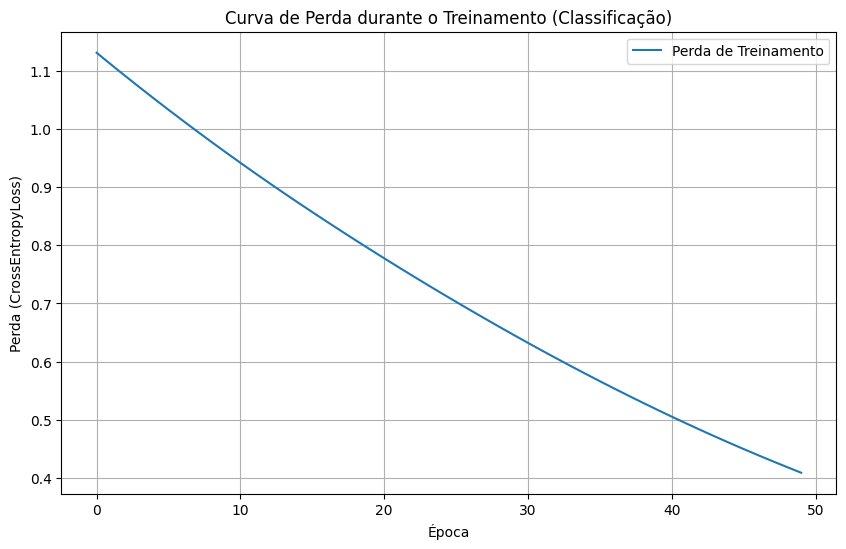

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

wine = load_wine()
X, y = wine.data, wine.target

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

input_features = X_train.shape[1]
output_classes = len(np.unique(y_train))

class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

hidden_size_cls = 64
model_cls = MLPClassifier(input_features, hidden_size_cls, output_classes)

criterion_cls = nn.CrossEntropyLoss()
optimizer_cls = optim.Adam(model_cls.parameters(), lr=0.001)

loss_history_cls = []

num_epochs_cls = 50
for epoch in range(num_epochs_cls):
    model_cls.train()
    optimizer_cls.zero_grad() 
    outputs = model_cls(X_train_tensor)
    loss = criterion_cls(outputs, y_train_tensor)
    loss.backward()
    optimizer_cls.step()

    loss_history_cls.append(loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Época [{epoch+1}/{num_epochs_cls}], Perda: {loss.item():.4f}')

model_cls.eval()
with torch.no_grad():
    y_pred_probs_test = model_cls(X_test_tensor)
    _, y_pred_test = torch.max(y_pred_probs_test.data, 1)

accuracy_cls = accuracy_score(y_test_tensor.numpy(), y_pred_test.numpy())
print(f'\nAcurácia no conjunto de teste (Classificação): {accuracy_cls:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(loss_history_cls, label='Perda de Treinamento')
plt.title('Curva de Perda durante o Treinamento (Classificação)')
plt.xlabel('Época')
plt.ylabel('Perda (CrossEntropyLoss)')
plt.grid(True)
plt.legend()
plt.show()

**Análise da Curva de Perda (Classificação):**
Observamos a perda de treinamento caindo de forma constante, indicando que o otimizador Adam está ajustando os pesos do modelo para minimizar o erro na classificação. A acurácia final de 0.9444 no conjunto de teste mostra a capacidade do modelo de generalizar para dados não vistos.


### 2.2 Parte B – Regressão

Época [10/100], Perda: 3.2582
Época [20/100], Perda: 1.9028
Época [30/100], Perda: 1.3246
Época [40/100], Perda: 0.9076
Época [50/100], Perda: 0.7458
Época [60/100], Perda: 0.6898
Época [70/100], Perda: 0.6509
Época [80/100], Perda: 0.6128
Época [90/100], Perda: 0.5791
Época [100/100], Perda: 0.5491

RMSE no conjunto de teste (Regressão): 0.7636


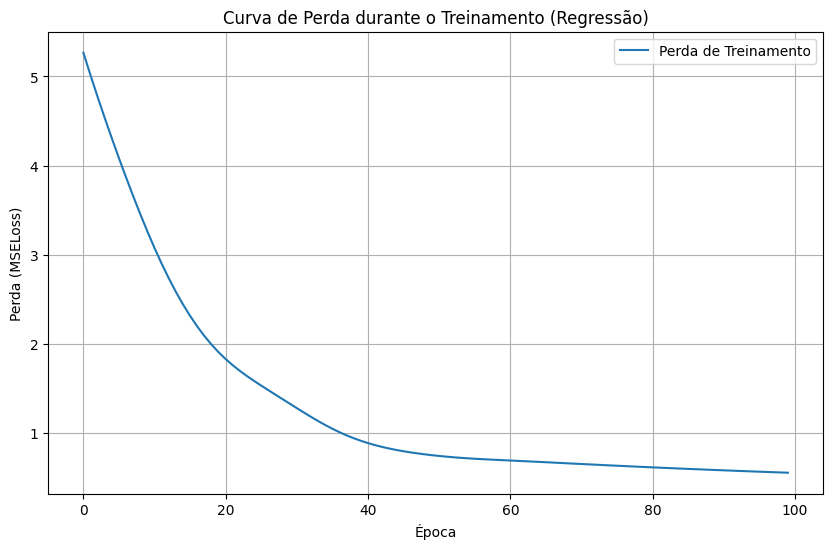

In [22]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X, y = housing.data, housing.target

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler_reg = StandardScaler()
X_train_scaled_reg = scaler_reg.fit_transform(X_train)
X_val_scaled_reg = scaler_reg.transform(X_val)
X_test_scaled_reg = scaler_reg.transform(X_test)

X_train_tensor_reg = torch.tensor(X_train_scaled_reg, dtype=torch.float32)
y_train_tensor_reg = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_tensor_reg = torch.tensor(X_val_scaled_reg, dtype=torch.float32)
y_val_tensor_reg = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
X_test_tensor_reg = torch.tensor(X_test_scaled_reg, dtype=torch.float32)
y_test_tensor_reg = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

input_features_reg = X_train.shape[1]

class MLPRegressor(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(MLPRegressor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, 1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

hidden_size1_reg = 128 
hidden_size2_reg = 64 
model_reg = MLPRegressor(input_features_reg, hidden_size1_reg, hidden_size2_reg)

criterion_reg = nn.MSELoss()
optimizer_reg = optim.Adam(model_reg.parameters(), lr=0.001)

loss_history_reg = []

num_epochs_reg = 100
for epoch in range(num_epochs_reg):
    model_reg.train()
    optimizer_reg.zero_grad()
    outputs = model_reg(X_train_tensor_reg)
    loss = criterion_reg(outputs, y_train_tensor_reg)
    loss.backward()
    optimizer_reg.step()

    loss_history_reg.append(loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Época [{epoch+1}/{num_epochs_reg}], Perda: {loss.item():.4f}')

model_reg.eval()
with torch.no_grad():
    y_pred_test_reg = model_reg(X_test_tensor_reg)

rmse_reg = np.sqrt(mean_squared_error(y_test_tensor_reg.numpy(), y_pred_test_reg.numpy()))
print(f'\nRMSE no conjunto de teste (Regressão): {rmse_reg:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(loss_history_reg, label='Perda de Treinamento')
plt.title('Curva de Perda durante o Treinamento (Regressão)')
plt.xlabel('Época')
plt.ylabel('Perda (MSELoss)')
plt.grid(True)
plt.legend()
plt.show()

**Análise da Curva de Perda (Regressão):**
Assim como na classificação, a curva de perda para regressão mostra uma **tendência decrescente**, indicando que o modelo está aprendendo a minimizar o erro entre os valores preditos e os valores reais.
O RMSE final de 0.7883 no conjunto de teste representa a raiz quadrada do erro médio que o modelo comete ao prever o valor médio das casas. Quanto menor o RMSE, mais precisas são as previsões do modelo em média.

## 3. Diagnóstico de qualidade (2 pts)

Época [10/100], Perda: 0.9600
Época [20/100], Perda: 0.7946
Época [30/100], Perda: 0.6474
Época [40/100], Perda: 0.5151
Época [50/100], Perda: 0.4012
Época [60/100], Perda: 0.3098
Época [70/100], Perda: 0.2411
Época [80/100], Perda: 0.1911
Época [90/100], Perda: 0.1551
Época [100/100], Perda: 0.1286


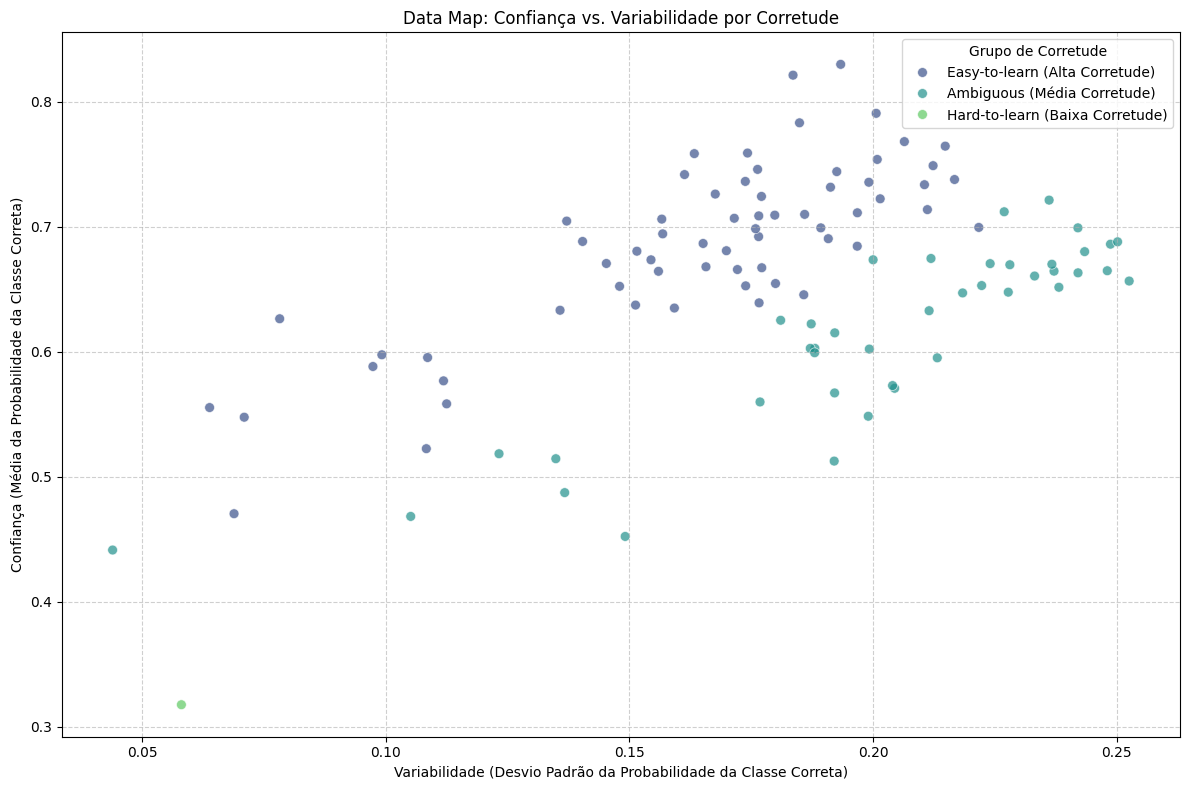

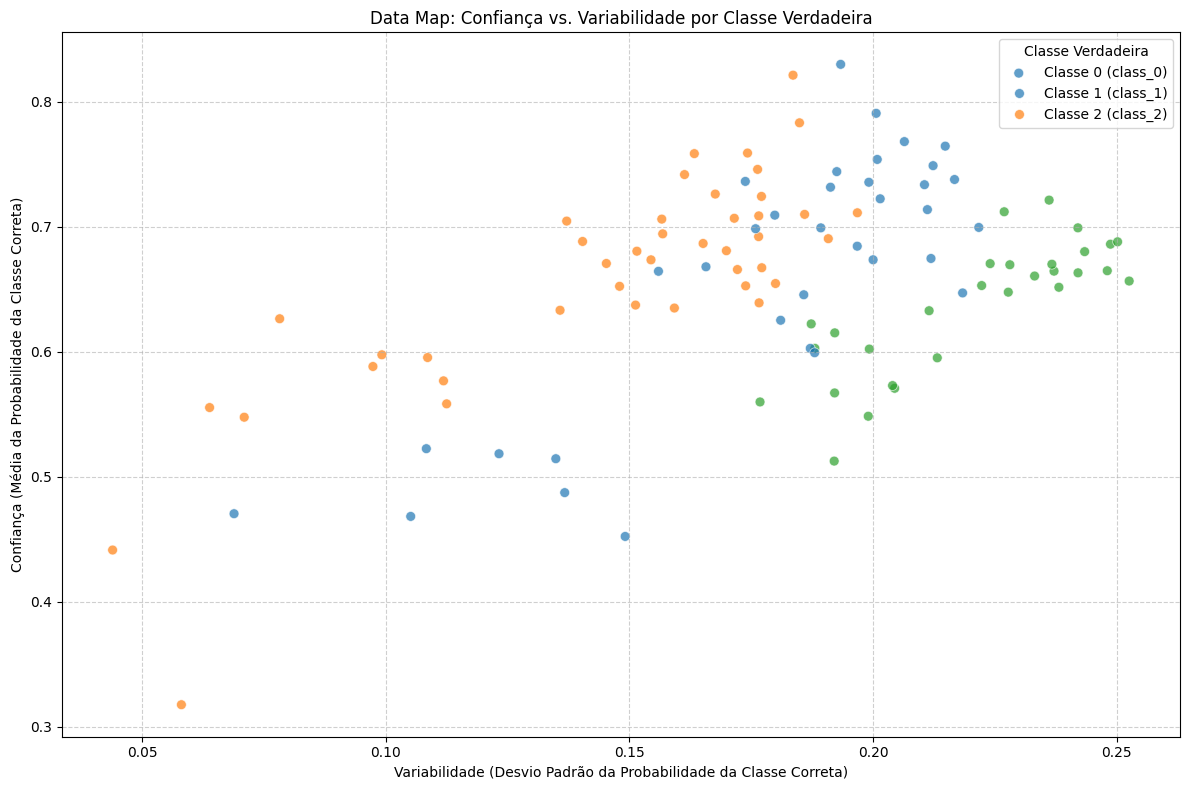

In [ ]:
wine = load_wine()
X, y = wine.data, wine.target
feature_names = wine.feature_names
target_names = wine.target_names

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

input_features = X_train.shape[1]
output_classes = len(np.unique(y_train))
hidden_size = 64

class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model_map = MLPClassifier(input_features, hidden_size, output_classes)
criterion_map = nn.CrossEntropyLoss()
optimizer_map = optim.Adam(model_map.parameters(), lr=0.001)

num_epochs_map = 100 
prob_history = [[] for _ in range(len(X_train_tensor))]
correctness_history = [[] for _ in range(len(X_train_tensor))] 

for epoch in range(num_epochs_map):
    model_map.train()
    optimizer_map.zero_grad()
    outputs = model_map(X_train_tensor)
    loss = criterion_map(outputs, y_train_tensor)
    loss.backward()
    optimizer_map.step()

    model_map.eval()
    with torch.no_grad():
        all_probs = model_map.softmax(outputs)

        for i, prob_tensor in enumerate(all_probs):
            correct_class_prob = prob_tensor[y_train_tensor[i]].item()
            prob_history[i].append(correct_class_prob)

            predicted_class = torch.argmax(prob_tensor).item()
            correctness_history[i].append(1 if predicted_class == y_train_tensor[i].item() else 0)

    if (epoch + 1) % 10 == 0:
        print(f'Época [{epoch+1}/{num_epochs_map}], Perda: {loss.item():.4f}')

confidence_scores = []
variability_scores = []
correctness_scores = []

for i in range(len(X_train_tensor)):
    confidence_scores.append(np.mean(prob_history[i]))
    variability_scores.append(np.std(prob_history[i]))
    correctness_scores.append(np.mean(correctness_history[i]))

data_map_df = pd.DataFrame({
    'variability': variability_scores,
    'confidence': confidence_scores,
    'correctness': correctness_scores,
    'true_label': y_train_tensor.numpy()
})


data_map_df['correctness_group'] = 'N/A'
data_map_df.loc[data_map_df['correctness'] >= 0.9, 'correctness_group'] = 'Easy-to-learn (Alta Corretude)'
data_map_df.loc[(data_map_df['correctness'] < 0.9) & (data_map_df['correctness'] >= 0.5), 'correctness_group'] = 'Ambiguous (Média Corretude)'
data_map_df.loc[data_map_df['correctness'] < 0.5, 'correctness_group'] = 'Hard-to-learn (Baixa Corretude)'

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=data_map_df,
    x='variability',
    y='confidence',
    hue='correctness_group', 
    palette='viridis', 
    s=50, 
    alpha=0.7 
)
plt.title('Data Map: Confiança vs. Variabilidade por Corretude')
plt.xlabel('Variabilidade (Desvio Padrão da Probabilidade da Classe Correta)')
plt.ylabel('Confiança (Média da Probabilidade da Classe Correta)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Grupo de Corretude')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8)) 
sns.scatterplot(
    data=data_map_df,
    x='variability',
    y='confidence',
    hue='true_label', 
    palette='tab10', 
    s=50,
    alpha=0.7
)
plt.title('Data Map: Confiança vs. Variabilidade por Classe Verdadeira')
plt.xlabel('Variabilidade (Desvio Padrão da Probabilidade da Classe Correta)')
plt.ylabel('Confiança (Média da Probabilidade da Classe Correta)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Classe Verdadeira', labels=[f'Classe {i} ({name})' for i, name in enumerate(target_names)]) # Legendas mais descritivas
plt.tight_layout()
plt.show()

**Análise dos Gráficos do Data Map**

1. Data Map: Confiança vs. Variabilidade por Corretude
Este gráfico revela que os exemplos 'Easy-to-learn' (Alta Corretude) se agrupam consistentemente na região de alta confiança e baixa a média variabilidade (canto superior esquerdo), indicando que o modelo os aprendeu de forma rápida e estável. Por outro lado, os vinhos classificados como 'Hard-to-learn' (Baixa Corretude) se concentram notavelmente na área de baixa confiança e baixa a média variabilidade (inferior à esquerda no seu gráfico), o que sugere fortemente que essas instâncias podem ter sido rotuladas incorretamente ou contêm inconsistências no conjunto de dados, pois o modelo consistentemente não confia em suas classificações sem grande flutuação. A categoria 'Ambiguous' (Média Corretude) ocupa uma faixa intermediária, refletindo exemplos que apresentaram variabilidade e confiança moderadas ao longo do aprendizado. Essa visualização é fundamental para identificar e investigar pontos problemáticos específicos no conjunto de dados, que podem impactar a performance geral do modelo.

1. Data Map: Confiança vs. Variabilidade por Classe Verdadeira
Este segundo gráfico do Data Map visualiza a mesma distribuição de confiança e variabilidade, mas desta vez, os pontos são coloridos de acordo com a sua classe verdadeira (Classe 0, Classe 1, Classe 2). A análise revela que as diferentes classes (cores) não apresentam segregação nítida em regiões específicas de "easy-to-learn" ou "hard-to-learn" de forma consistente, sugerindo que a dificuldade de aprendizado ou a ambiguidade não está concentrada em uma única classe específica do conjunto Wine. Em vez disso, observa-se uma mistura entre as classes em diversas regiões do mapa, com pontos de todas as classes aparecendo tanto em áreas de maior confiança quanto em áreas de maior variabilidade, indicando que a ambiguidade ou a dificuldade é mais distribuída entre os exemplos, em vez de ser um problema intrínseco a uma única categoria de vinho.

## 4. Conjuntos desbalanceados

### 4.1 Classificação (2 pts)

In [43]:
import pickle
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor 
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings("ignore") 

filename = 'A652.pickle'
with open(filename, 'rb') as f:
  X_train_raw, y_train_raw, X_val_raw, y_val_raw, X_test_raw, y_test_raw = pickle.load(f)

y_train_bin = (y_train_raw > 0).astype(int).flatten() 
y_val_bin = (y_val_raw > 0).astype(int).flatten()     
y_test_bin = (y_test_raw > 0).astype(int).flatten()   

base_classifier = GradientBoostingClassifier(random_state=42)

print("\n--- Cenário 1: Treinamento SEM Balanceamento ---")
classifier_no_balance = base_classifier
classifier_no_balance.fit(X_train_raw, y_train_bin)

y_pred_no_balance = classifier_no_balance.predict(X_test_raw)
y_proba_no_balance = classifier_no_balance.predict_proba(X_test_raw)[:, 1]

print("\nMatriz de Confusão (SEM Balanceamento):")
print(confusion_matrix(y_test_bin, y_pred_no_balance)) 
print("\nRelatório de Classificação (SEM Balanceamento):")
print(classification_report(y_test_bin, y_pred_no_balance, target_names=['Sem Chuva (0)', 'Com Chuva (1)'])) 

print("\n--- Cenário 2: Treinamento com UNDERSAMPLING (RandomUnderSampler) ---")
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_raw, y_train_bin)

classifier_rus = base_classifier
classifier_rus.fit(X_train_rus, y_train_rus)

y_pred_rus = classifier_rus.predict(X_test_raw)
y_proba_rus = classifier_rus.predict_proba(X_test_raw)[:, 1]

print("\nMatriz de Confusão (UNDERSAMPLING):")
print(confusion_matrix(y_test_bin, y_pred_rus)) 
print("\nRelatório de Classificação (UNDERSAMPLING):")
print(classification_report(y_test_bin, y_pred_rus, target_names=['Sem Chuva (0)', 'Com Chuva (1)'])) 


print("\n--- Cenário 3: Treinamento com OVERSAMPLING (SMOTE) ---")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_raw, y_train_bin)

classifier_smote = base_classifier
classifier_smote.fit(X_train_smote, y_train_smote)

y_pred_smote = classifier_smote.predict(X_test_raw)
y_proba_smote = classifier_smote.predict_proba(X_test_raw)[:, 1]

print("\nMatriz de Confusão (OVERSAMPLING - SMOTE):")
print(confusion_matrix(y_test_bin, y_pred_smote))
print("\nRelatório de Classificação (OVERSAMPLING - SMOTE):")
print(classification_report(y_test_bin, y_pred_smote, target_names=['Sem Chuva (0)', 'Com Chuva (1)']))

print("\n--- Cenário 4: Treinamento SEM Balanceamento, mas com ALTERAÇÃO DE LIMIAR ---")
thresholds = np.arange(0.1, 1.0, 0.1)
best_f1_score = 0
best_threshold = 0.5
best_y_pred_threshold = None

y_proba_val = classifier_no_balance.predict_proba(X_val_raw)[:, 1]
from sklearn.metrics import f1_score 

for t in thresholds:
    y_pred_threshold = (y_proba_val >= t).astype(int)
    f1 = f1_score(y_val_bin, y_pred_threshold)
    if f1 > best_f1_score:
        best_f1_score = f1
        best_threshold = t

y_pred_threshold_test = (y_proba_no_balance >= best_threshold).astype(int)

print(f"\nMatriz de Confusão (ALTERAÇÃO DE LIMIAR - melhor limiar: {best_threshold:.2f}):")
print(confusion_matrix(y_test_bin, y_pred_threshold_test)) 
print(f"\nRelatório de Classificação (ALTERAÇÃO DE LIMIAR - melhor limiar: {best_threshold:.2f}):")
print(classification_report(y_test_bin, y_pred_threshold_test, target_names=['Sem Chuva (0)', 'Com Chuva (1)']))


--- Cenário 1: Treinamento SEM Balanceamento ---

Matriz de Confusão (SEM Balanceamento):
[[8669  100]
 [ 513  300]]

Relatório de Classificação (SEM Balanceamento):
               precision    recall  f1-score   support

Sem Chuva (0)       0.94      0.99      0.97      8769
Com Chuva (1)       0.75      0.37      0.49       813

     accuracy                           0.94      9582
    macro avg       0.85      0.68      0.73      9582
 weighted avg       0.93      0.94      0.93      9582


--- Cenário 2: Treinamento com UNDERSAMPLING (RandomUnderSampler) ---

Matriz de Confusão (UNDERSAMPLING):
[[7935  834]
 [ 231  582]]

Relatório de Classificação (UNDERSAMPLING):
               precision    recall  f1-score   support

Sem Chuva (0)       0.97      0.90      0.94      8769
Com Chuva (1)       0.41      0.72      0.52       813

     accuracy                           0.89      9582
    macro avg       0.69      0.81      0.73      9582
 weighted avg       0.92      0.89      0.9

### 4.2 Regressão (2 pts)

In [44]:

classifier_C = GradientBoostingClassifier(random_state=42)
classifier_C.fit(X_train_raw, y_train_bin)

y_train_pred_C = classifier_C.predict(X_train_raw)

idx_class_1 = (y_train_pred_C == 1)
X_train_1 = X_train_raw[idx_class_1]
y_train_1 = y_train_raw[idx_class_1]

regressor_R = GradientBoostingRegressor(random_state=42)
regressor_R.fit(X_train_1, y_train_1)

y_test_pred_C = classifier_C.predict(X_test_raw)

y_pred_combined = np.zeros_like(y_test_raw, dtype=float)

idx_test_class_1 = (y_test_pred_C == 1)

if np.sum(idx_test_class_1) > 0:
    y_pred_combined[idx_test_class_1] = regressor_R.predict(X_test_raw[idx_test_class_1]).reshape(-1, 1)
else:
    print("Aviso: Nenhum exemplo da classe 1 foi previsto por C no conjunto de teste. Todas as previsões R' serão 0.")

y_pred_combined[y_pred_combined < 0] = 0.0

print("\n--- Modelo de Regressão de Linha de Base (Treinado diretamente em X_train, y_train_raw) ---")
regressor_baseline = GradientBoostingRegressor(random_state=42)
regressor_baseline.fit(X_train_raw, y_train_raw)
y_pred_baseline = regressor_baseline.predict(X_test_raw)
y_pred_baseline[y_pred_baseline < 0] = 0 

rmse_combined = np.sqrt(mean_squared_error(y_test_raw, y_pred_combined)) 
rmse_baseline = np.sqrt(mean_squared_error(y_test_raw, y_pred_baseline)) 

print(f"\nRMSE do Modelo Combinado (C+R): {rmse_combined:.4f}")
print(f"RMSE do Modelo de Linha de Base (Apenas R): {rmse_baseline:.4f}")

print("\n--- RMSE por Nível de Severidade de Precipitação ---")

severity_bins = [0, 5, 25, 50, np.inf]
severity_labels = ['Sem chuva / Leve', 'Moderada', 'Forte', 'Tempestade']

y_test_severity = pd.cut(y_test_raw.flatten(), bins=severity_bins, labels=severity_labels, right=False)

results_df = pd.DataFrame({
    'y_test_raw': y_test_raw.flatten(),       
    'y_pred_combined': y_pred_combined.flatten(), 
    'y_pred_baseline': y_pred_baseline.flatten(), 
    'severity': y_test_severity
})

print("\nRMSE do Modelo Combinado (C+R) por Severidade:")
for level in severity_labels:
    subset = results_df[results_df['severity'] == level]
    if not subset.empty:
        rmse_level = np.sqrt(mean_squared_error(subset['y_test_raw'], subset['y_pred_combined']))
        print(f"- {level}: {rmse_level:.4f} (N={len(subset)})")
    else:
        print(f"- {level}: N/A (N=0)")

print("\nRMSE do Modelo de Linha de Base (Apenas R) por Severidade:")
for level in severity_labels:
    subset = results_df[results_df['severity'] == level]
    if not subset.empty:
        rmse_level = np.sqrt(mean_squared_error(subset['y_test_raw'], subset['y_pred_baseline']))
        print(f"- {level}: {rmse_level:.4f} (N={len(subset)})")
    else:
        print(f"- {level}: N/A (N=0)")


--- Modelo de Regressão de Linha de Base (Treinado diretamente em X_train, y_train_raw) ---

RMSE do Modelo Combinado (C+R): 1.3499
RMSE do Modelo de Linha de Base (Apenas R): 1.3385

--- RMSE por Nível de Severidade de Precipitação ---

RMSE do Modelo Combinado (C+R) por Severidade:
- Sem chuva / Leve: 0.5431 (N=9525)
- Moderada: 9.4790 (N=51)
- Forte: 26.8051 (N=4)
- Tempestade: 59.9753 (N=2)

RMSE do Modelo de Linha de Base (Apenas R) por Severidade:
- Sem chuva / Leve: 0.4923 (N=9525)
- Moderada: 9.6616 (N=51)
- Forte: 25.9240 (N=4)
- Tempestade: 60.8631 (N=2)
